### Introduction

This is an example of how to use this notebook. For more information about the project, see the [README](README.md). 

This notebook is intended to be used as a starting point for students who are interested in learning about the chemometrics in the context of fermentation technology. 

This exercise uses spectral data collected in _real-time_ during a lignocellulosic ethanol fermentation. These samples were taken using attenuated total refractance, mid infrared (ATR-MIR) spectroscopy. and the reference data was taken using high performance liquid chromatography (HPLC). 

The datasets used in this project consist of:

- Training dataset (containing both, spectra and the corresponding HPLC measurements).

- Fermentation dataset: containing a timeseries of spectra collected in real time, and another timeseries of off-line HPLC measurements. 

For detailed information about the training and fermentation datasets, see  _Transforming data to information: A parallel hybrid model for real-time state estimation in lignocellulosic ethanol fermentation_.



### Imports

In [1]:
from dtuprosys.chemometrics.modelling.cross_validation import cross_validation
from dtuprosys.chemometrics.datasets import load_fermentation_data, load_train_data
from dtuprosys.chemometrics.plotting import plot_spectra, plot_predictions, plot_fermentation
from dtuprosys.chemometrics.preprocessing import RangeCut, Derivative, DriftCorrection
from mbpls.mbpls import MBPLS

## 1. Train the model

### 1.1. Load training data

Train data is directly loaded using the ```load_train_data()``` function.

In [2]:
train_spectra, train_hplc = load_train_data()

In [3]:
# Run this cell to get the dimensions of the train_spectra table and assign it to the variable train_spectra.
dimensions_train_spectra = train_spectra.shape

# Find the dimensions of the train_hplc and assign it to the variable dimensions_train_hplc.
# Write your code below:
dimensions_train_hplc = train_hplc.shape

print("The train_spectra table has {} rows and {} columns.".format(dimensions_train_spectra[0], dimensions_train_spectra[1]))
print("The train_hplc table has {} rows and {} columns.".format(dimensions_train_hplc[0], dimensions_train_hplc[1]))

The train_spectra table has 21 rows and 1047 columns.
The train_hplc table has 21 rows and 1 columns.


### 1.2. Preprocess the training data

We will focus on the fingerprinting area of the spectra. The fingerprinting area is a region in the MIR spectrum where many organic compounds show characteristic absorbance bands. For this reason, the first step will be to cut the spectra to the interval of the fingerprinting area.

Next we pre-process the spectra. The objective of the preprocessing is to remove systematic variation in the spectra and to highlight important features of the spectra. A good review on preprocessing techniques in spectra can be found in the following paper: _Review of the most common pre-processing techniques for near-infrared spectra_.

In this case, we choose to pre-process the spectra using 1st derivative. 

In [4]:
range_cut = RangeCut(950,1550)
derivate = Derivative(1)
drift_correction = DriftCorrection()

range_cut_spectra = range_cut.apply_to(train_spectra)
drift_corrected_spectra = drift_correction.apply_to(range_cut_spectra)
derivate_spectra = derivate.apply_to(drift_corrected_spectra)

preprocessed_spectra = derivate_spectra

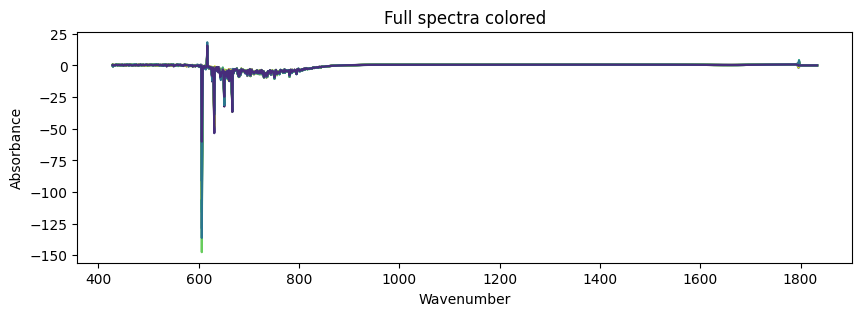

In [5]:
range_cut2 = RangeCut(900,1700)
range_cut_spectra2 = range_cut2.apply_to(train_spectra)
plot_spectra(train_spectra, "Full spectra colored", "Wavenumber", "Absorbance", reference=train_hplc)

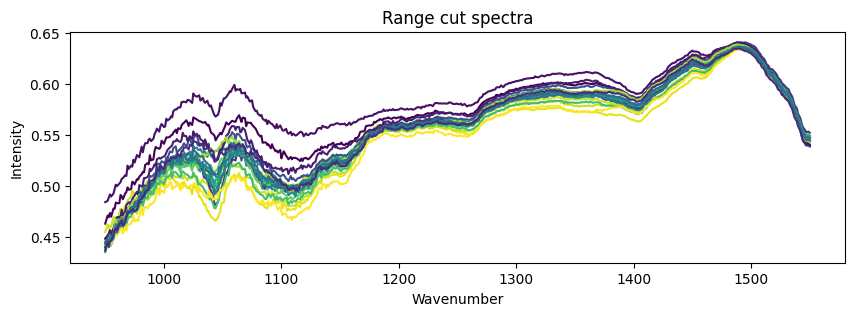

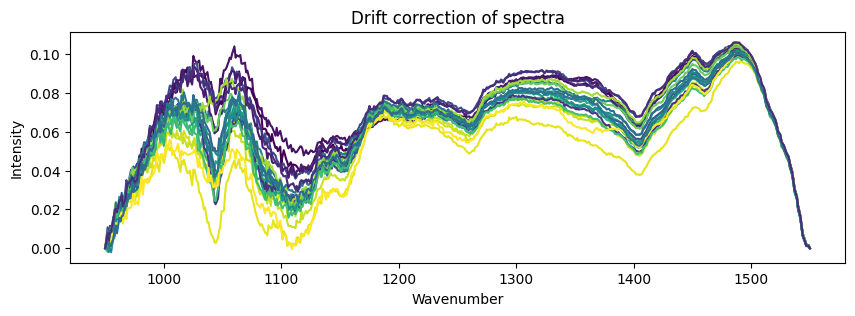

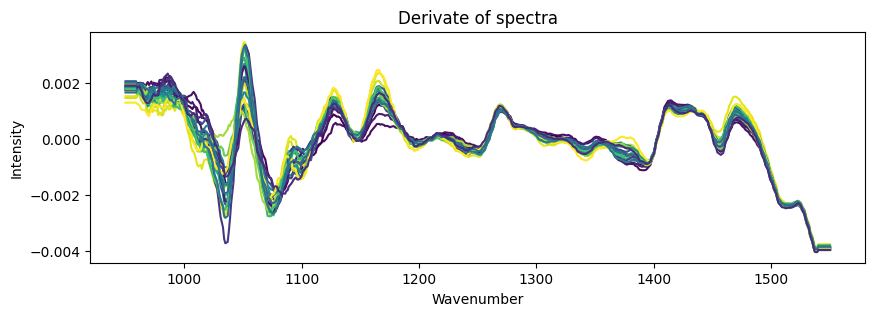

In [6]:
plot_spectra(range_cut_spectra, "Range cut spectra", "Wavenumber", "Intensity", reference=train_hplc)
plot_spectra(drift_corrected_spectra, "Drift correction of spectra", "Wavenumber", "Intensity", reference=train_hplc)
plot_spectra(derivate_spectra, "Derivate of spectra", "Wavenumber", "Intensity", reference=train_hplc)

### 1.3. Use cross validation to find the best model

The next step is training the PLS model. To do so, we first need to specify the number of components to use in the PLS model. This can be achieved using a corssvalidation procedure. In this example, we have wrapped the cross validation routines inside functions that provide useful information to evaluate the PLS models with different number of components. This is done using the function ```cross_validation()```. This function will output a plot showing the RMSE and RMSECV (Root Mean Squared Error and Root Mean Squared Error of the Cross Validation) for the different number of components.


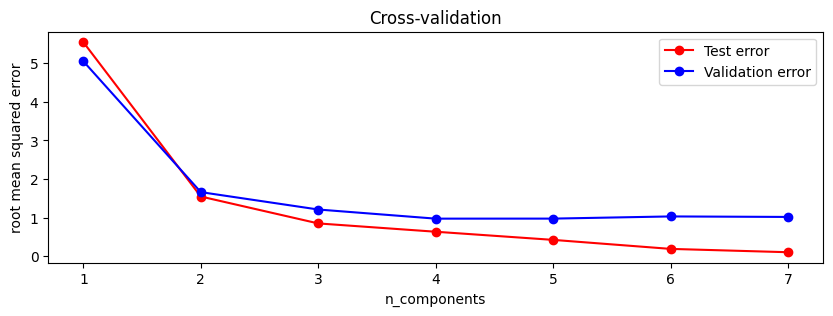

In [7]:
cross_validation(preprocessed_spectra, train_hplc)

We can see that the optimal would have between 3 to 5 latent variables. For simplicity of the model, we choose one with only 3 latent variables. 

Therefore, we train the model using the the training data and 3 latent variables. We can visualize the performance of the trained model using the ```plot_predictions()``` function, which will output a plot showing the predictions of the model for the training data.

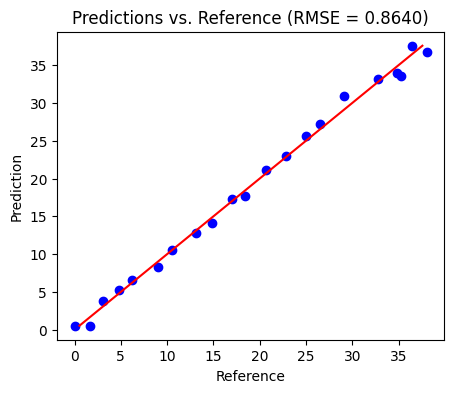

In [8]:
model = MBPLS(n_components=3, method='NIPALS')
prediction = model.fit_predict(preprocessed_spectra, train_hplc)
plot_predictions(predictions=prediction, reference=train_hplc)

### 2. Apply the model

2.1. Load the fermentation data

The fermentation data can be loaded directly using the ```load_fermentation_data()``` function.

In [9]:
fermentation_spectra, fermentation_hplc = load_fermentation_data()

### 2.2. Preprocess the fermentation data

We need to preprocess the fermentation data in the same way as we processed the training data.

In [10]:
fermentation_spectra_range_cut = range_cut.apply_to(fermentation_spectra)
fermentation_spectra_drift_correction = drift_correction.apply_to(fermentation_spectra_range_cut)
fermentation_spectra_derivate = derivate.apply_to(fermentation_spectra_drift_correction)

### 2.3. Make predictions with the trained PLS models

The PLS models that was trained in the __Section 1.3__ is now used to make predictions on the fermentation data. The predictions can be visualized using the ```plot_predictions()``` function.

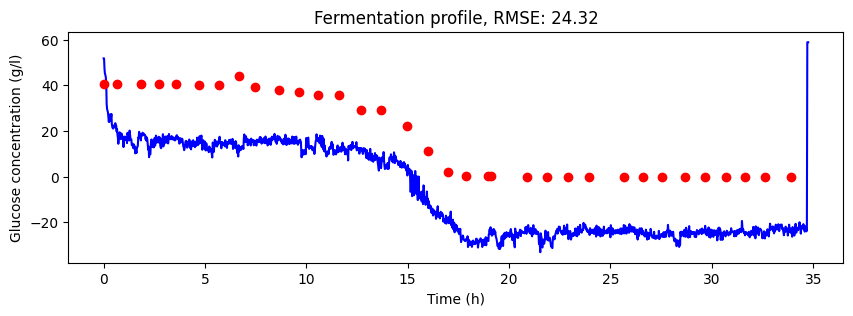

In [11]:
prediction = model.predict(fermentation_spectra_derivate)
plot_fermentation(prediction, fermentation_hplc)